In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ETH-USD.csv to ETH-USD.csv


In [ ]:
import io
import pandas as pd

df_ETH = pd.read_csv(io.BytesIO(uploaded['ETH-USD.csv']))
df_ETH.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0


In [ ]:
#Importing libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [ ]:
df_ETH.shape

(2109, 7)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text major ticklabel objects>)

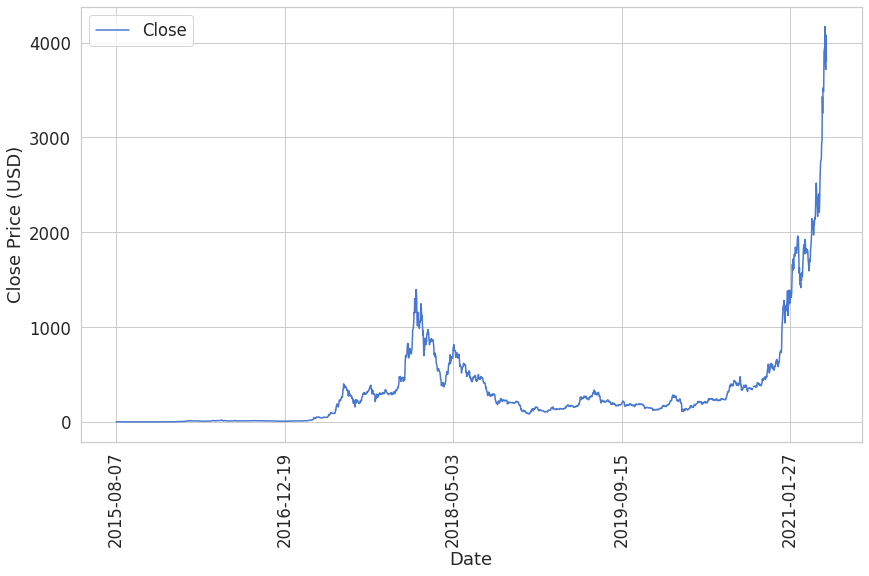

In [ ]:
ax = df_ETH.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
plt.xticks(rotation=90)

In [ ]:
scaler = MinMaxScaler()

#The scaler expects the data to be shaped as (x, y), so we add a dummy dimension using reshape before applying it.
#Add close column of ETH's values to close_price after reshaping
close_price = df_ETH.Close.values.reshape(-1, 1)
#^Here we added another dummy dimension as tranformation works only after that
scaled_close = scaler.fit_transform(close_price)
#^Here we transformed the close prices to normalize them

In [ ]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

Pre-processing
Defining sequences for training and testing
LSTMs expect the data to be in 3 dimensions. We need to split the data into sequences of some preset length. The shape we want to obtain is: [batch_size, sequence_length, n_features]

In [ ]:
##MAJOR QUESTION

In [ ]:
##DATA WAS STORED IN SCALED_CLOSE TILL NOW. BUT IT IS NOT USED AFTER THIS. WHY , WHERE AND WHAT IS USED THEN?
##
##
##
##
##
##
##
###
###
##
##
##
##

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])


##Num train is 95% of data

#:Numtrain means from starting to 95% of data
    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]


#Numtrain: means start after 95% of data
    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_test.shape
X_train.shape

(1904, 99, 1)

In [ ]:
#Model
#Bidirectional RNNs allows you to train on the sequence data in forward and backward (reversed) direction.
#CuDNNLSTM is a “Fast LSTM implementation backed by cuDNN”

DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [ ]:
#Training
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
27/27 [==============================] - 15s 198ms/step - loss: 0.0026 - val_loss: 0.0094
Epoch 2/50
27/27 [==============================] - 4s 148ms/step - loss: 0.0051 - val_loss: 0.0137
Epoch 3/50
27/27 [==============================] - 4s 149ms/step - loss: 0.0038 - val_loss: 0.0112
Epoch 4/50
27/27 [==============================] - 4s 147ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 5/50
27/27 [==============================] - 4s 150ms/step - loss: 0.0010 - val_loss: 4.6856e-04
Epoch 6/50
27/27 [==============================] - 4s 149ms/step - loss: 5.3770e-04 - val_loss: 6.7670e-04
Epoch 7/50
27/27 [==============================] - 4s 151ms/step - loss: 1.9079e-04 - val_loss: 4.3303e-04
Epoch 8/50
27/27 [==============================] - 4s 151ms/step - loss: 1.4678e-04 - val_loss: 0.0013
Epoch 9/50
27/27 [==============================] - 4s 150ms/step - loss: 4.0667e-04 - val_loss: 0.0018
Epoch 10/50
27/27 [==============================] - 4s 151ms/step - lo

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 70ms/step - loss: 0.0098


0.009812409058213234

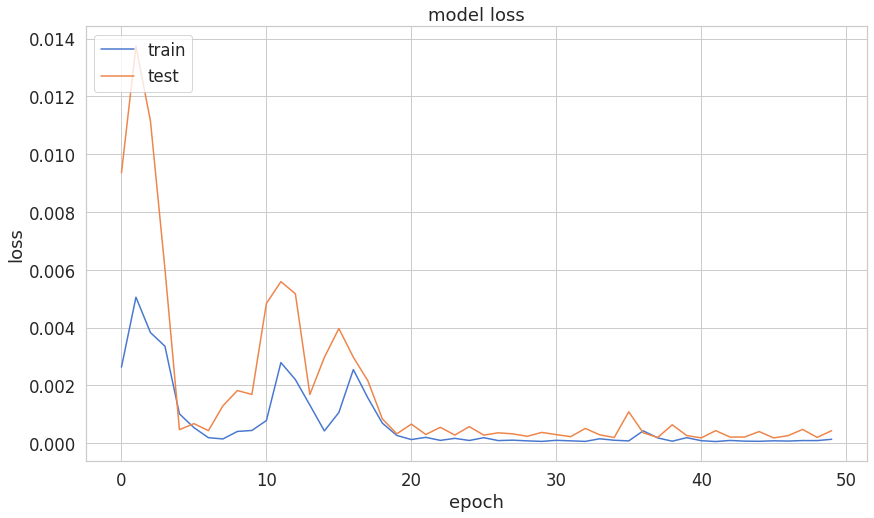

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

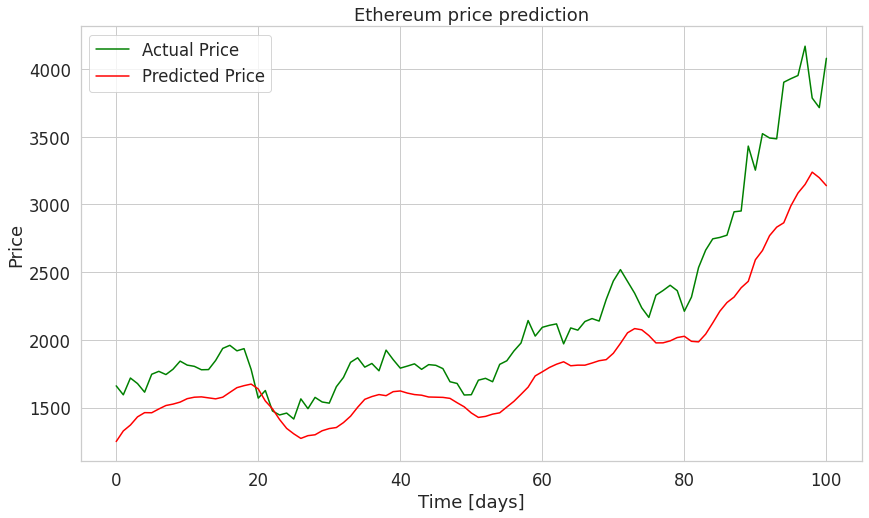

In [ ]:
#Prediction
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [ ]:
from sklearn.metrics import mean_absolute_error
rf_val_mae = mean_absolute_error(y_test_inverse,y_hat_inverse)  #  "Actual Price"  , "Predicted Price"
rf_val_mae

349.6346036923733

In [ ]:
rmse = np.sqrt(((y_hat_inverse - y_test_inverse) ** 2).mean())
print('Mean Squared Error: {}'.format(round(rmse, 2)))

Mean Squared Error: 412.9


In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test_inverse, y_hat_inverse)

0.6202738814923254

R² score tells us how well our model is fitted to the data by comparing it to the average line of the dependent variable. If the score is closer to 1, then it indicates that our model performs well versus if the score is farther from 1, then it indicates that our model does not perform so well.